In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import sys
from gpflow.ci_utils import ci_niter
sys.path.append('../code')
from gplar import GPLARegressor
from gpar.regression import GPARRegressor

In [2]:
data = np.load('eeg_exchange.npy', allow_pickle=True).item()

eeg_all,      eeg_train,      eeg_test      = data['eeg']
exchange_all, exchange_train, exchange_test = data['exchange']

## EEG

In [46]:
x_eeg = np.array(eeg_train.index).reshape(256,1)
y_eeg = np.array(eeg_train) 

In [47]:
means_eeg, stds_eeg = [],[]
for i, name in enumerate(eeg_train.columns):
    available = ~np.isnan(y_eeg[:,i])
    y_i = y_eeg[available, i]
    means_eeg.append(np.mean(y_i))
    stds_eeg.append(np.std(y_i))
means_eeg, stds_eeg = np.stack(means_eeg), np.stack(stds_eeg)

def normalise_y(y_, means, stds): return (y_ - means)/stds
def unnormalise_y(y_, means, stds): return y_*stds + means

y_eeg_normalise = normalise_y(y_eeg ,means_eeg, stds_eeg)

In [48]:
from gpar.regression import GPARRegressor
model = GPARRegressor(scale=0.02,
                          linear=False, nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=True)
model.fit(x_eeg, y_eeg)
means_ee, lowers_ee, uppers_ee = \
        model.predict(x_eeg, num_samples=100, credible_bounds=True, latent=True)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [49]:
gpar = GPARRegressor(scale=0.02,
                          linear=False, nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=False)
M = 256

m_c_eeg = GPLARegressor(x_eeg, y_eeg_normalise, M, gpar, white=False,
                 scale=0.02,
                 linear=False,
                 nonlinear=True, nonlinear_scale=1.0,
                 noise_inner=1e-5, noise_obs=0.01,
                 num_samples=1)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [50]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%50 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

In [51]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(8000)
logf = run_adam(m_c_eeg, (x_eeg,y_eeg_normalise), maxiter)

-168270.31635596164
-2082.1552956481282
-1077.9164037955045
-684.5029791622945
-467.1961924237671
-325.02325874928715
-180.22789667515713
11.204886574409784
76.20905069307537
182.1211212808264
251.76934018160955
401.6013025503812
585.4370344327203
726.8081293870382
770.9725554155034
789.9288640960986


In [52]:
gpflow.utilities.print_summary(m_c_eeg, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.inducing_inputs.Z GPLARegressor.layers[0].inducing_points,Parameter,,,True,"(256, 1)",float64,[[-2.59414860e-03...
GPLARegressor.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.0011560139354450942
GPLARegressor.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.0011230703458997092
GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.0007229908056339179
GPLARegressor.likelihoods[3].variance,Parameter,Softplus + Shift,,True,(),float64,0.0018455795668477963
GPLARegressor.likelihoods[4].variance,Parameter,Softplus + Shift,,True,(),float64,0.001999347831204469
GPLARegressor.likelihoods[5].variance,Parameter,Softplus + Shift,,True,(),float64,0.002639645619000824
GPLARegressor.likelihoods[6].variance,Parameter,Softplus + Shift,,True,(),float64,0.002907307035281999
GPLARegressor.layers[0].q_mu,Parameter,,,True,"(256, 1)",float64,[[1.46980353...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(256, 256)",float64,"[[7.09099794e-02, 0.00000000e+00, 0.00000000e+00..."


In [13]:
Hmeans_c, Hvars_c = m_c_eeg.predict_f(x_eeg, 100)
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, std = np.mean(Hmeans,axis=0), np.sqrt(np.mean(Hvars, axis=0))
    mean, std = unnormalise_y(mean, means_eeg, stds_eeg), stds_eeg*std
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y_eeg = getMeanandBound(Hmeans_c, Hvars_c)

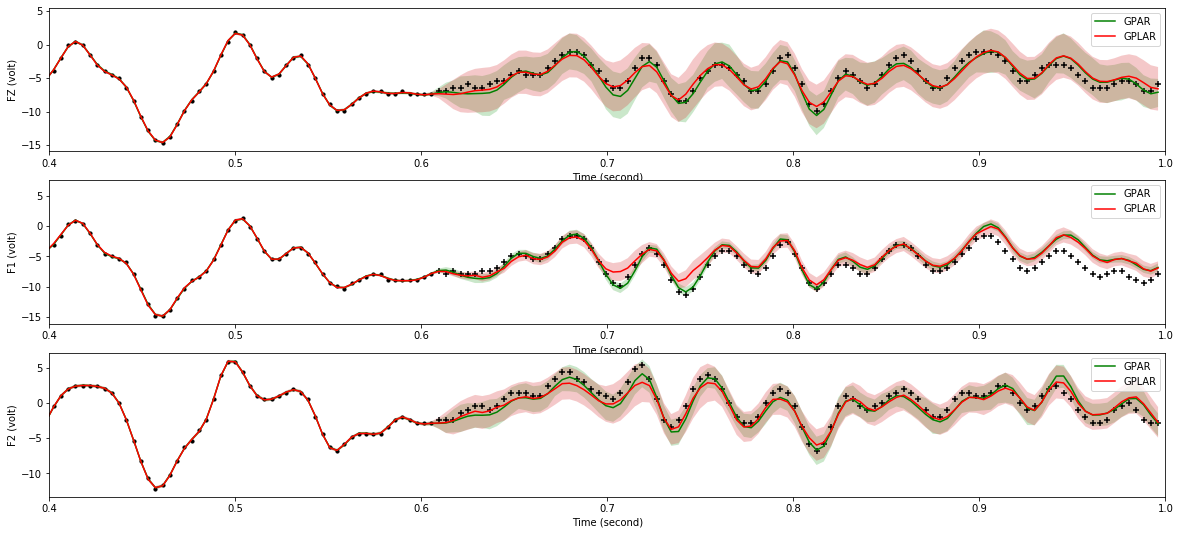

In [14]:
plt.figure(figsize=(20, 9))
x = np.array(eeg_train.index)
for i, name in enumerate(eeg_test.columns):
    p = list(eeg_train.columns).index(name)  # Index of output.
    plt.subplot(3, 1, i + 1)
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    plt.scatter(x, y_eeg[:, p], c='black', s=10)
    plt.scatter(eeg_test[name].index, eeg_test[name], c='black', marker= '+')
    plt.xlabel('Time (second)')
    plt.xlim(0.4, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg.png', dpi=400)

In [15]:
import pandas as pd
pred_ee = pd.DataFrame(means_ee, index=eeg_train.index, columns=eeg_train.columns)
smse_ee = ((pred_ee - eeg_test) ** 2).mean().mean() / \
           ((eeg_test.mean(axis=0) - eeg_test) ** 2).mean().mean()
    
pred_ee_GPLAR = pd.DataFrame(predict_y_eeg[0], index=eeg_train.index, columns=eeg_train.columns)
smse_ee_GPLAR = ((pred_ee_GPLAR - eeg_test) ** 2).mean().mean() / \
           ((eeg_test.mean(axis=0) - eeg_test) ** 2).mean().mean()

print('SMSE-eeg-GPAR:', smse_ee)
print('SMSE-eeg-GPLAR:', smse_ee_GPLAR)

SMSE-eeg-GPAR: 0.2149333821386208
SMSE-eeg-GPLAR: 0.23578742775972528


In [9]:
def predict_log_density(model, train, test, num_samples, full_cov=False):
    Xnew = np.array(test.index).reshape(-1,1)
    Hmean, Hvar = model._predict(Xnew, full_cov=full_cov, S=num_samples)
    log_density = []
    for i, name in enumerate(test.columns):
        Ynew = np.array(test[name])
        p = list(train.columns).index(name)
        mu = Hmean[p][:,:,0] * stds_eeg[p] + means_eeg[p] #[S,N]
        var = Hvar[p][:,:,0] * stds_eeg[p]**2 + model.likelihoods[p].variance #[S,N]
        l = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Ynew - mu)/var) #[S,N]
        log_num_samples = tf.math.log(tf.cast(num_samples, l.dtype))
        log_likelihood = tf.reduce_sum(tf.reduce_logsumexp(l - log_num_samples, axis=0)) #[N,] -> scalar
        log_density.append([name, log_likelihood.numpy()])
    return log_density

def predict_log_likelihood_gpar(model, train, test, num_samples):
    Xnew = np.array(test.index)
    means_ee, lowers_ee, uppers_ee = model.predict(Xnew, num_samples=num_samples, credible_bounds=True, latent=True)
    log_density = []
    for i, name in enumerate(test.columns):
        Ynew = np.array(test[name])
        p = list(train.columns).index(name)
        mu = means_ee[:,p] #[N,]
        var = ((uppers_ee[:,p] - means_ee[:,p])/1.96)**2 #[N,]
        log_likelihood = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Ynew - mu)/var) #[N,]
        log_density.append([name, np.sum(log_likelihood)])
    return log_density

In [10]:
predict_log_density(m_c_eeg, eeg_train, eeg_test, 100)

[['FZ', -151.7073290405172],
 ['F1', -174.24081858033446],
 ['F2', -143.07073456154694]]

In [12]:
predict_log_likelihood_gpar(model, eeg_train, eeg_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[['FZ', -140.0979441574487],
 ['F1', -752.9900421090425],
 ['F2', -130.68833305312845]]

## EXCHANGE

In [16]:
x_ex = np.array(exchange_train.index).reshape(251, 1)
y_ex = np.array(exchange_train) 

In [17]:
means_exchange, stds_exchange = [],[]
for i, name in enumerate(exchange_train.columns):
    available = ~np.isnan(y_ex[:,i])
    y_i = y_ex[available, i]
    means_exchange.append(np.mean(y_i))
    stds_exchange.append(np.std(y_i))
means_exchange, stds_exchange = np.stack(means_exchange), np.stack(stds_exchange)

In [18]:
y_ex_normalise = normalise_y(y_ex, means_exchange, stds_exchange)

In [19]:
model = GPARRegressor(scale=0.1,
                          linear=True, linear_scale=10.,
                          nonlinear=True, nonlinear_scale=1.,
                          rq=True,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=True)
model.fit(x_ex, y_ex)
means_ex, lowers_ex, uppers_ex = \
    model.predict(x_ex, num_samples=100, credible_bounds=True, latent=False)

Training conditionals (total: 13): 1 2 3 4 5 6 7 8 9 10 11 12 13
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [20]:
gpar = GPARRegressor(scale=0.1,
                          linear=True, linear_scale=10.,
                          nonlinear=True, nonlinear_scale=1.,
                          rq=True,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=False)
M = 251

m_c_exchange = GPLARegressor(x_ex, y_ex_normalise, M, gpar, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.,
                 nonlinear=True, nonlinear_scale=1.,
                 rq=True,
                 noise_inner=1e-5, noise_obs=0.01,
                 num_samples=1)

Training conditionals (total: 13): 1 2 3 4 5 6 7 8 9 10 11 12 13
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


In [21]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%50 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

from gpflow.ci_utils import ci_niter
maxiter = ci_niter(8000)
logf = run_adam(m_c_exchange, (x_ex, y_ex_normalise), maxiter)

-23300.387595985256
-1469.1392427829546
-283.25332079422947
134.53638669584484
210.6432270185892
277.14021443363845
368.67320590682175
384.7876930397035
461.4212206278112
493.61527222275936
505.27231955584375
521.8640162706188
581.2597643571689
599.494611110696
568.7296479137258
582.9892888075733


In [22]:
Hmeans_c, Hvars_c = m_c_exchange.predict_f(x_ex, 100)
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, std = np.mean(Hmeans,axis=0), np.sqrt(np.mean(Hvars, axis=0))
    mean, std = unnormalise_y(mean, means_exchange, stds_exchange), stds_exchange*std
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y_exchange = getMeanandBound(Hmeans_c, Hvars_c)

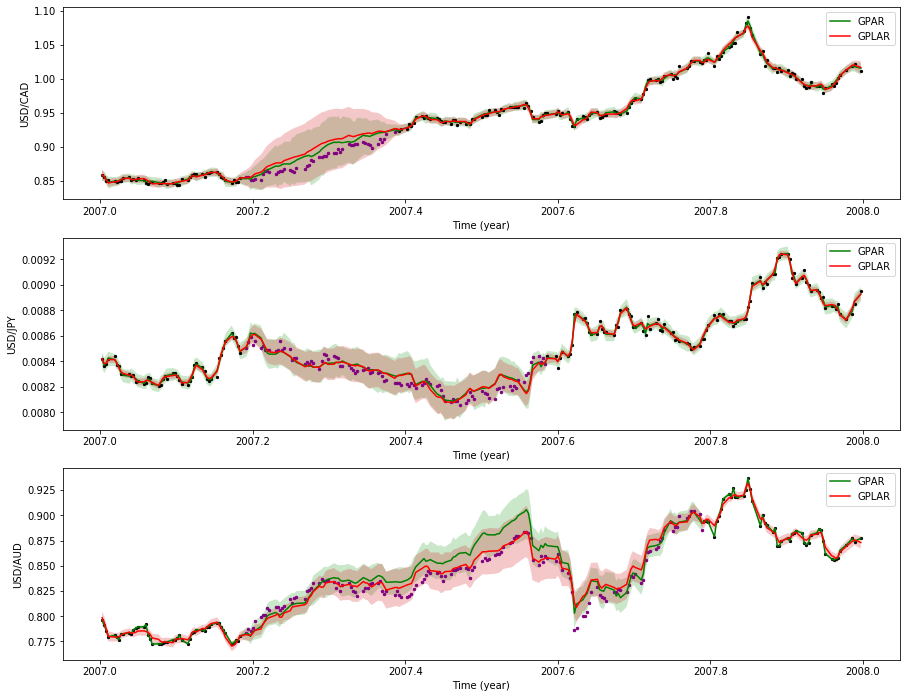

In [23]:
plt.figure(figsize=(15, 12))
x = np.array(exchange_train.index)
for i, name in enumerate(exchange_test.columns):
    p = list(exchange_train.columns).index(name)  # Index of output.
    plt.subplot(3, 1, i + 1)
    plt.plot(x, means_ex[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ex[:, p], uppers_ex[:, p], facecolor='tab:green', alpha=.25)
    plt.plot(x, predict_y_exchange[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_exchange[1][:, p], predict_y_exchange[2][:, p], facecolor='tab:red', alpha=.25)
    plt.scatter(x, y_ex[:, p], c='black', s=5)
    plt.scatter(exchange_test[name].index, exchange_test[name], c='purple', s=6)
    plt.xlabel('Time (year)')
    plt.ylabel(name)
    plt.legend()
plt.savefig('exchange.png', dpi=300)

In [24]:
pred_ex = pd.DataFrame(means_ex, index=exchange_train.index, columns=exchange_train.columns)
smse_ex = ((pred_ex - exchange_test) ** 2).mean(axis=0) / \
           ((exchange_train.mean(axis=0) - exchange_test) ** 2).mean(axis=0)
    
pred_ex_GPLAR = pd.DataFrame(predict_y_exchange[0], index=exchange_train.index, columns=exchange_train.columns)
smse_ex_GPLAR = ((pred_ex_GPLAR - exchange_test) ** 2).mean(axis=0) / \
           ((exchange_train.mean(axis=0) - exchange_test) ** 2).mean(axis=0)
    
print('SMSE-exchange-GPAR:')
print('USD/CAD:', smse_ex['USD/CAD'])
print('USD/JPY:', smse_ex['USD/JPY'])
print('USD/AUD:', smse_ex['USD/AUD'])
print('SMSE-exchange-GPLAR:')
print('USD/CAD:', smse_ex_GPLAR['USD/CAD'])
print('USD/JPY:', smse_ex_GPLAR['USD/JPY'])
print('USD/AUD:', smse_ex_GPLAR['USD/AUD'])

SMSE-exchange-GPAR:
USD/CAD: 0.02232800997578962
USD/JPY: 0.025191831290903615
USD/AUD: 0.19416634626241955
SMSE-exchange-GPLAR:
USD/CAD: 0.04738456837952834
USD/JPY: 0.02605513126499927
USD/AUD: 0.07901375432598405


In [32]:
def predict_log_density(model, train, test, num_samples, full_cov=False):
    Xnew = np.array(test.index).reshape(-1,1)
    Hmean, Hvar = model._predict(Xnew, full_cov=full_cov, S=num_samples)
    log_density = []
    for i, name in enumerate(test.columns):
        Ynew = np.array(test[name])
        Ynew = Ynew[~np.isnan(Ynew)]
        p = list(train.columns).index(name)
        mu = Hmean[p][:,:len(Ynew),0] * stds_exchange[p] + means_exchange[p]
        var = Hvar[p][:,:len(Ynew),0] * stds_exchange[p]**2 + model.likelihoods[p].variance
        l = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Ynew - mu)/var)
        log_num_samples = tf.math.log(tf.cast(num_samples, l.dtype))
        log_likelihood = tf.reduce_sum(tf.reduce_logsumexp(l - log_num_samples, axis=0))
        log_density.append([name, log_likelihood.numpy()])
    return log_density

def predict_log_density_gpar(model, train, test, num_samples):
    Xnew = np.array(test.index)
    means_ex, lowers_ex, uppers_ex = model.predict(Xnew, num_samples=num_samples, credible_bounds=True, latent=True)
    log_density = []
    for i, name in enumerate(test.columns):
        Ynew = np.array(test[name])
        Ynew = Ynew[~np.isnan(Ynew)]
        p = list(train.columns).index(name)
        mu = means_ex[:len(Ynew),p]
        var = ((uppers_ex[:len(Ynew),p] - means_ex[:len(Ynew),p])/1.96)**2
        log_likelihood = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Ynew - mu)/var)
        log_density.append([name, np.sum(log_likelihood)])
    return log_density

In [33]:
predict_log_density(m_c_exchange, exchange_train, exchange_test, 100)

[['USD/CAD', 67.16654624226214],
 ['USD/JPY', 135.5707323099018],
 ['USD/AUD', 201.80646292062366]]

In [27]:
predict_log_density_gpar(model, exchange_train, exchange_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[['USD/CAD', 155.83273252101532],
 ['USD/JPY', 849.3356562611349],
 ['USD/AUD', 421.6901261749231]]

### Permute Missing Values -- EEG

In [12]:
data = np.load('eeg_exchange.npy', allow_pickle=True).item()
eeg_all,      eeg_train,      eeg_test      = data['eeg']
eeg_train_2 = eeg_all
eeg_train_2['F5'].iloc[150:200] = None
eeg_train_2['F6'].iloc[150:200] = None
eeg_train_2['FZ'].iloc[150:200] = None
eeg_train_2['F1'].iloc[150:200] = None
eeg_train_2['F2'].iloc[150:200] = None

In [13]:
x_eeg = np.array(eeg_train_2.index).reshape(256,1)
y_eeg = np.array(eeg_train_2)

In [14]:
means_eeg, stds_eeg = [],[]
for i, name in enumerate(eeg_train_2.columns):
    available = ~np.isnan(y_eeg[:,i])
    y_i = y_eeg[available, i]
    means_eeg.append(np.mean(y_i))
    stds_eeg.append(np.std(y_i))
means_eeg, stds_eeg = np.stack(means_eeg), np.stack(stds_eeg)

def normalise_y(y_, means, stds): return (y_ - means)/stds
def unnormalise_y(y_, means, stds): return y_*stds + means

y_eeg_normalise = normalise_y(y_eeg ,means_eeg, stds_eeg)

In [15]:
model_p = GPARRegressor(scale=0.02,
                          linear=True, linear_scale=10.0,
                          nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=True)
model_p.fit(x_eeg, y_eeg)
means_ee, lowers_ee, uppers_ee = \
        model_p.predict(x_eeg, num_samples=100, credible_bounds=True, latent=True)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [16]:
gpar_p = GPARRegressor(scale=0.02,
                          linear=True, linear_scale=10.0,
                          nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=False)
M = 256

m_c_eeg_p_2 = GPLARegressor(x_eeg, y_eeg_normalise, M, gpar_p, white=False,
                 scale=0.02,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=1.0,
                 noise_inner=1e-5, noise_obs=0.01,
                 num_samples=1)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [37]:
m_c_eeg_p_2.layers[1].kernel += gpflow.kernels.SquaredExponential(active_dims=[0], 
                                                 variance=1.0,
                                                 lengthscales=0.01)
m_c_eeg_p_2.layers[2].kernel += gpflow.kernels.SquaredExponential(active_dims=[0], 
                                                 variance=1.0,
                                                 lengthscales=0.01)

In [25]:
for i in range(3,4):
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].q_mu, False)
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].q_sqrt, False)

In [21]:
for i in range(4,7):
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].q_mu, False)
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].q_sqrt, False)

In [18]:
for i in range(3,7):
    #inner noise
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[0].variance, False)
    #output linear
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[1].variance, False)
    #output nonlinear
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[2].variance, False)
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[2].lengthscales, False)

for i in range(1,3):
    #inner noise
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[0].variance, False)
    #output linear
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[1].variance, False)
    #output nonlinear
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[2].variance, False)
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[2].lengthscales, False)
    #input nonlinear
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[3].variance, False)
    gpflow.set_trainable(m_c_eeg_p_2.layers[i].kernel.kernels[3].lengthscales, False)
    
gpflow.set_trainable(m_c_eeg_p_2.layers[0].kernel.kernels[0].variance, False)
gpflow.set_trainable(m_c_eeg_p_2.layers[0].kernel.kernels[1].variance, False)
gpflow.set_trainable(m_c_eeg_p_2.layers[0].kernel.kernels[1].lengthscales, False)

In [19]:
for i in range(0,7):
    gpflow.set_trainable(m_c_eeg_p_2.likelihoods[i].variance , False)

In [ ]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%50 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

from gpflow.ci_utils import ci_niter
maxiter = ci_niter(5000)
logf = run_adam(m_c_exchange, (x_ex, y_ex_normalise), maxiter)

In [22]:
gpflow.utilities.print_summary(m_c_eeg_p, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.inducing_inputs.Z GPLARegressor.layers[0].inducing_points,Parameter,,,True,"(256, 1)",float64,[[-0.00251049...
GPLARegressor.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.001150327639217978
GPLARegressor.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.0012584661329746133
GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.0008622021198441699
GPLARegressor.likelihoods[3].variance,Parameter,Softplus + Shift,,True,(),float64,0.0031083547778639597
GPLARegressor.likelihoods[4].variance,Parameter,Softplus + Shift,,True,(),float64,0.0028455520564287296
GPLARegressor.likelihoods[5].variance,Parameter,Softplus + Shift,,True,(),float64,0.0034352918889713558
GPLARegressor.likelihoods[6].variance,Parameter,Softplus + Shift,,True,(),float64,0.0020011925338611486
GPLARegressor.layers[0].q_mu,Parameter,,,True,"(256, 1)",float64,[[1.31937216e+00...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(256, 256)",float64,"[[5.97219329e-02, 0.00000000e+00, 0.00000000e+00..."


In [27]:
gpflow.utilities.print_summary(m_c_eeg_p_2, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.inducing_inputs.Z GPLARegressor.layers[0].inducing_points,Parameter,,,False,"(256, 1)",float64,[[0....
GPLARegressor.likelihoods[0].variance,Parameter,Softplus + Shift,,False,(),float64,0.03446859993690766
GPLARegressor.likelihoods[1].variance,Parameter,Softplus + Shift,,False,(),float64,0.2545386939667492
GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,False,(),float64,0.09373659660450626
GPLARegressor.likelihoods[3].variance,Parameter,Softplus + Shift,,False,(),float64,0.19108058836253
GPLARegressor.likelihoods[4].variance,Parameter,Softplus + Shift,,False,(),float64,0.06964887962351438
GPLARegressor.likelihoods[5].variance,Parameter,Softplus + Shift,,False,(),float64,0.03861718402383857
GPLARegressor.likelihoods[6].variance,Parameter,Softplus + Shift,,False,(),float64,0.12487974818766619
GPLARegressor.layers[0].q_mu,Parameter,,,True,"(256, 1)",float64,[[1.17438838...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(256, 256)",float64,"[[3.52557068e-02, 0.00000000e+00, 0.00000000e+00..."


In [29]:
gpflow.utilities.print_summary(m_c_eeg_p_2, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.inducing_inputs.Z GPLARegressor.layers[0].inducing_points,Parameter,,,False,"(256, 1)",float64,[[0....
GPLARegressor.likelihoods[0].variance,Parameter,Softplus + Shift,,False,(),float64,0.0096238560350274
GPLARegressor.likelihoods[1].variance,Parameter,Softplus + Shift,,False,(),float64,0.0019000017431010524
GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,False,(),float64,0.0011194012780920365
GPLARegressor.likelihoods[3].variance,Parameter,Softplus + Shift,,False,(),float64,0.057074515250688726
GPLARegressor.likelihoods[4].variance,Parameter,Softplus + Shift,,False,(),float64,0.019685664121840238
GPLARegressor.likelihoods[5].variance,Parameter,Softplus + Shift,,False,(),float64,0.0031428558097702244
GPLARegressor.likelihoods[6].variance,Parameter,Softplus + Shift,,False,(),float64,0.037235027108431365
GPLARegressor.layers[0].q_mu,Parameter,,,False,"(256, 1)",float64,[[1.20761053...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,False,"(256, 256)",float64,"[[2.44674603e-02, 0.00000000e+00, 0.00000000e+00..."


In [18]:
data = np.load('eeg_exchange.npy', allow_pickle=True).item()
eeg_all,      eeg_train,      eeg_test      = data['eeg']
eeg_test_2 = eeg_all[['F5','F6','FZ','F1','F2']].iloc[150:200]

In [19]:
Hmeans_c, Hvars_c = m_c_eeg_p_2.predict_f(x_eeg, 100)
observation_variance = []
for i in range(y_eeg.shape[1]):
    observation_variance.append(m_c_eeg_p_2.likelihoods[i].variance.value().numpy())
observation_var = np.array(observation_variance)

def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, var = np.mean(Hmeans,axis=0), np.mean(Hvars, axis=0)
    mean, std = unnormalise_y(mean, means_eeg, stds_eeg), stds_eeg*np.sqrt(var+observation_var)
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y_eeg = getMeanandBound(Hmeans_c, Hvars_c)

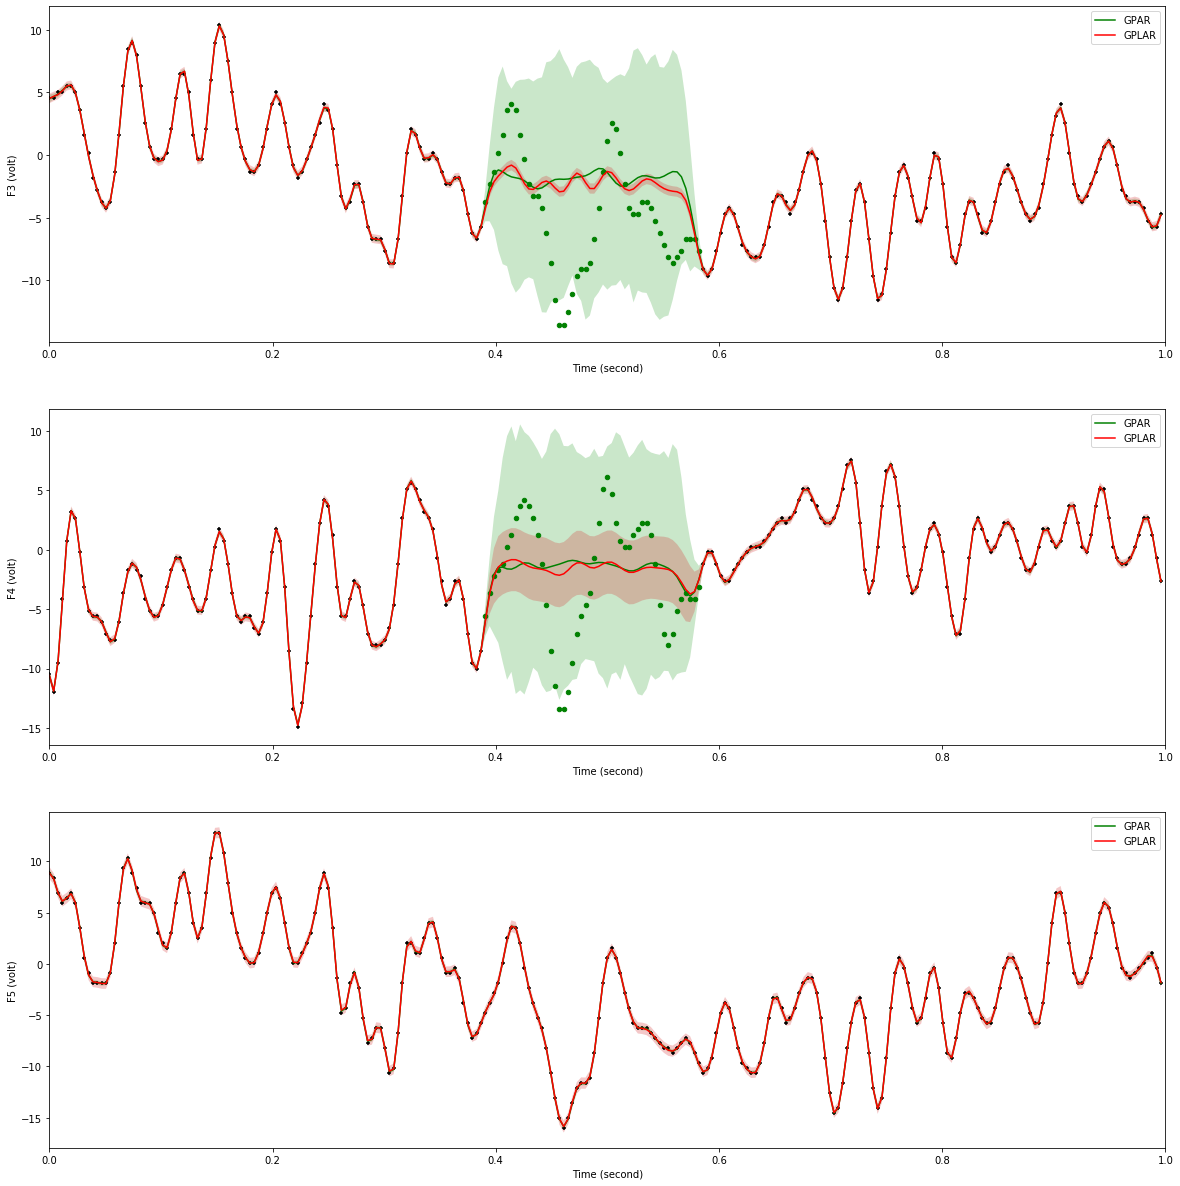

In [13]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_3.index)
for i, name in enumerate(eeg_train_3.columns):
    p = list(eeg_train_3.columns).index(name)  # Index of output.
    plt.subplot(3, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_3.columns:
        plt.scatter(eeg_test_3[name].index, eeg_test_3[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

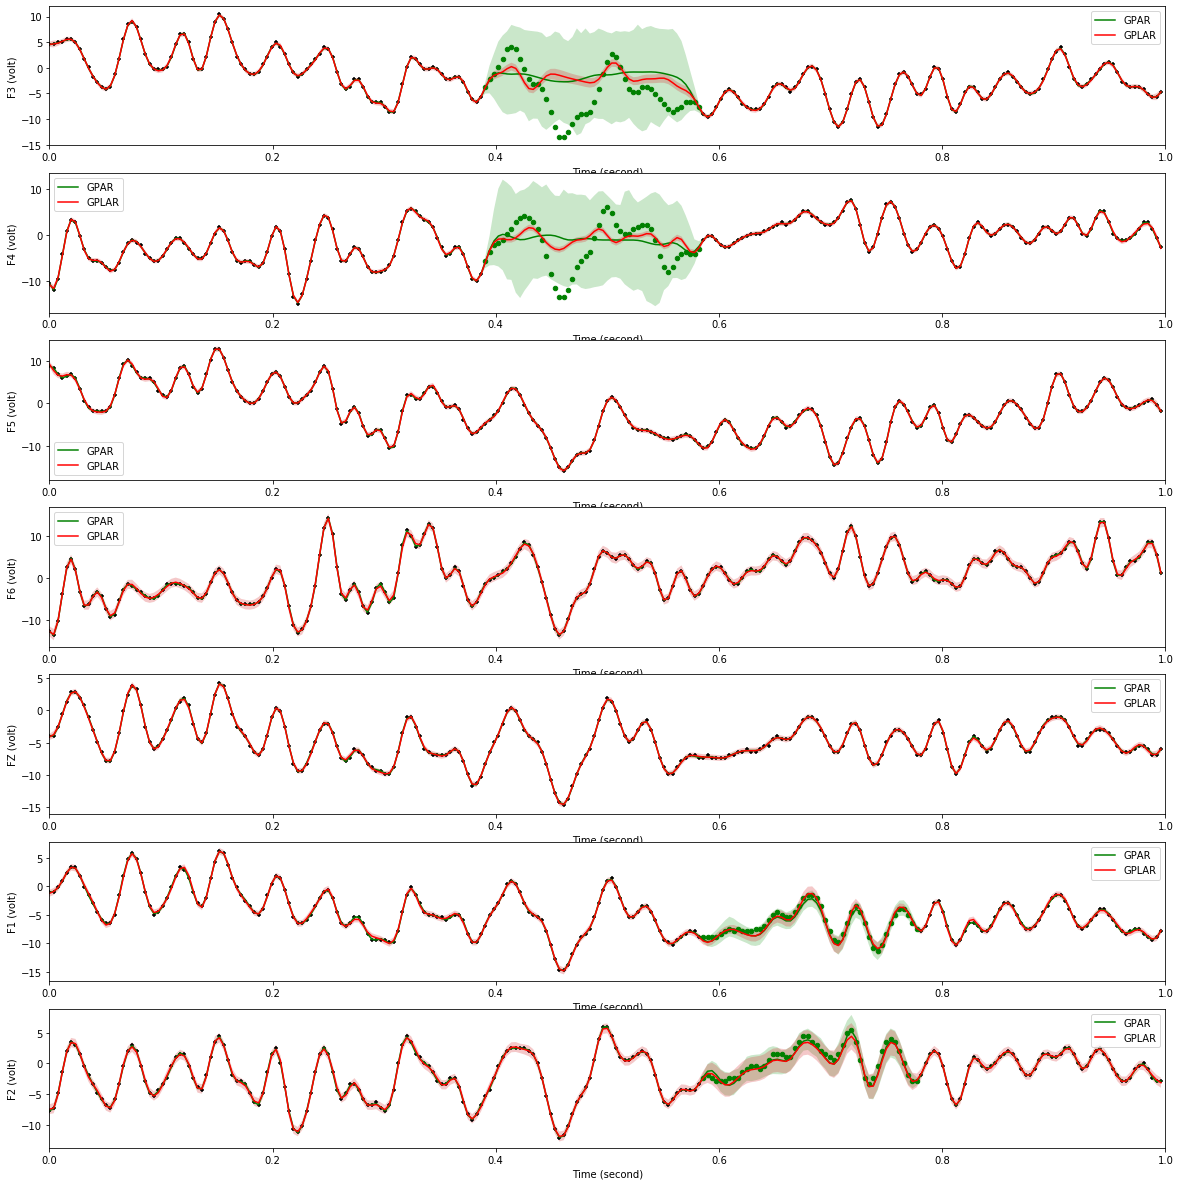

In [88]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_1.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

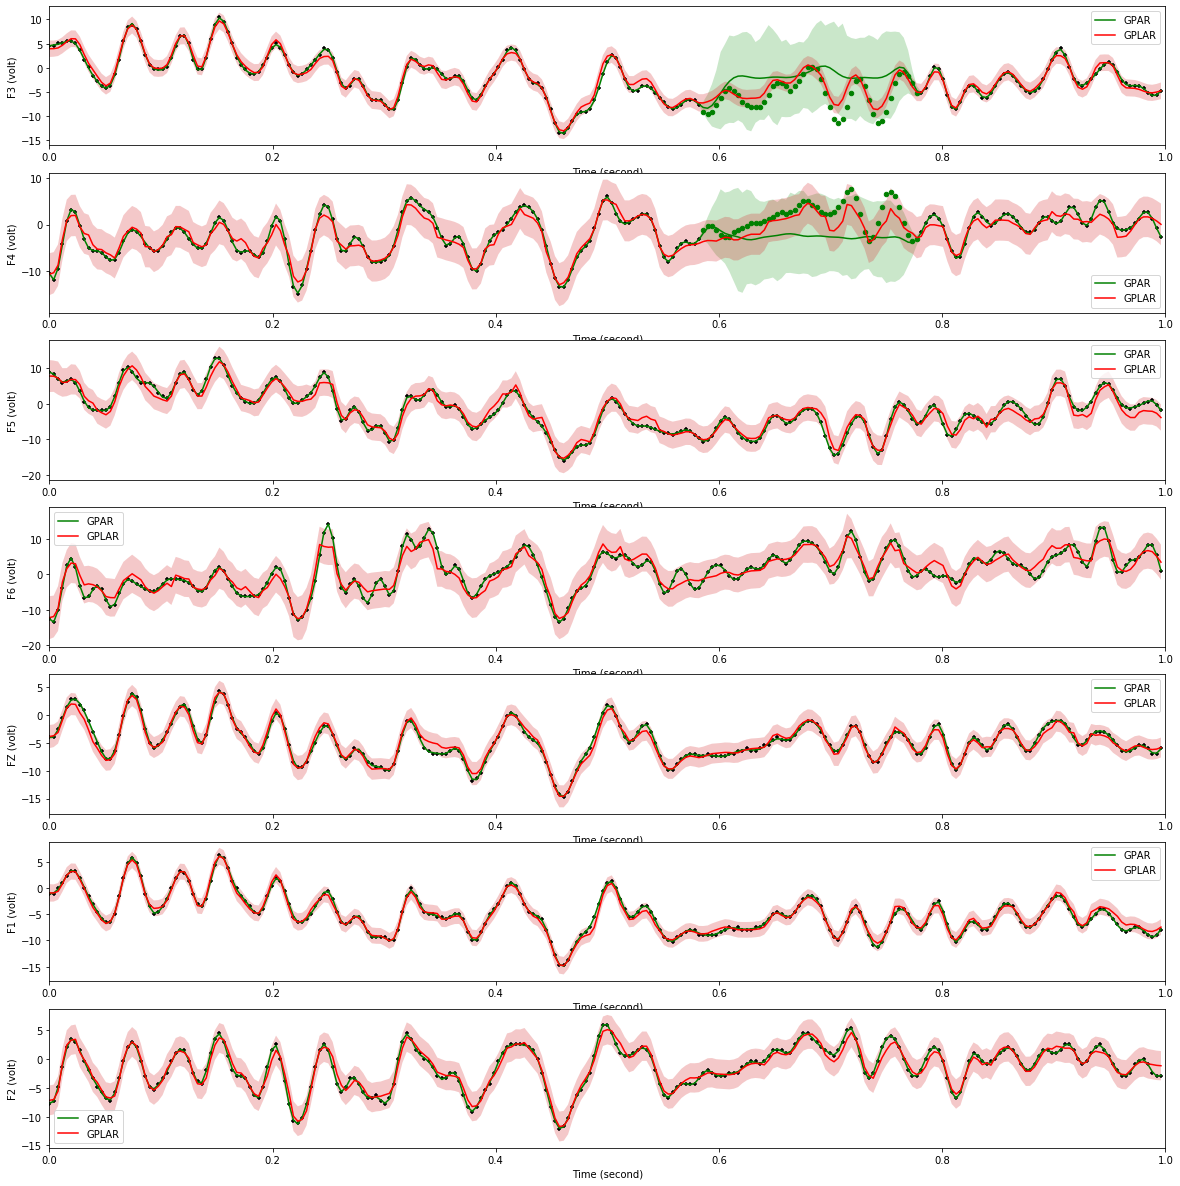

In [35]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_2.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

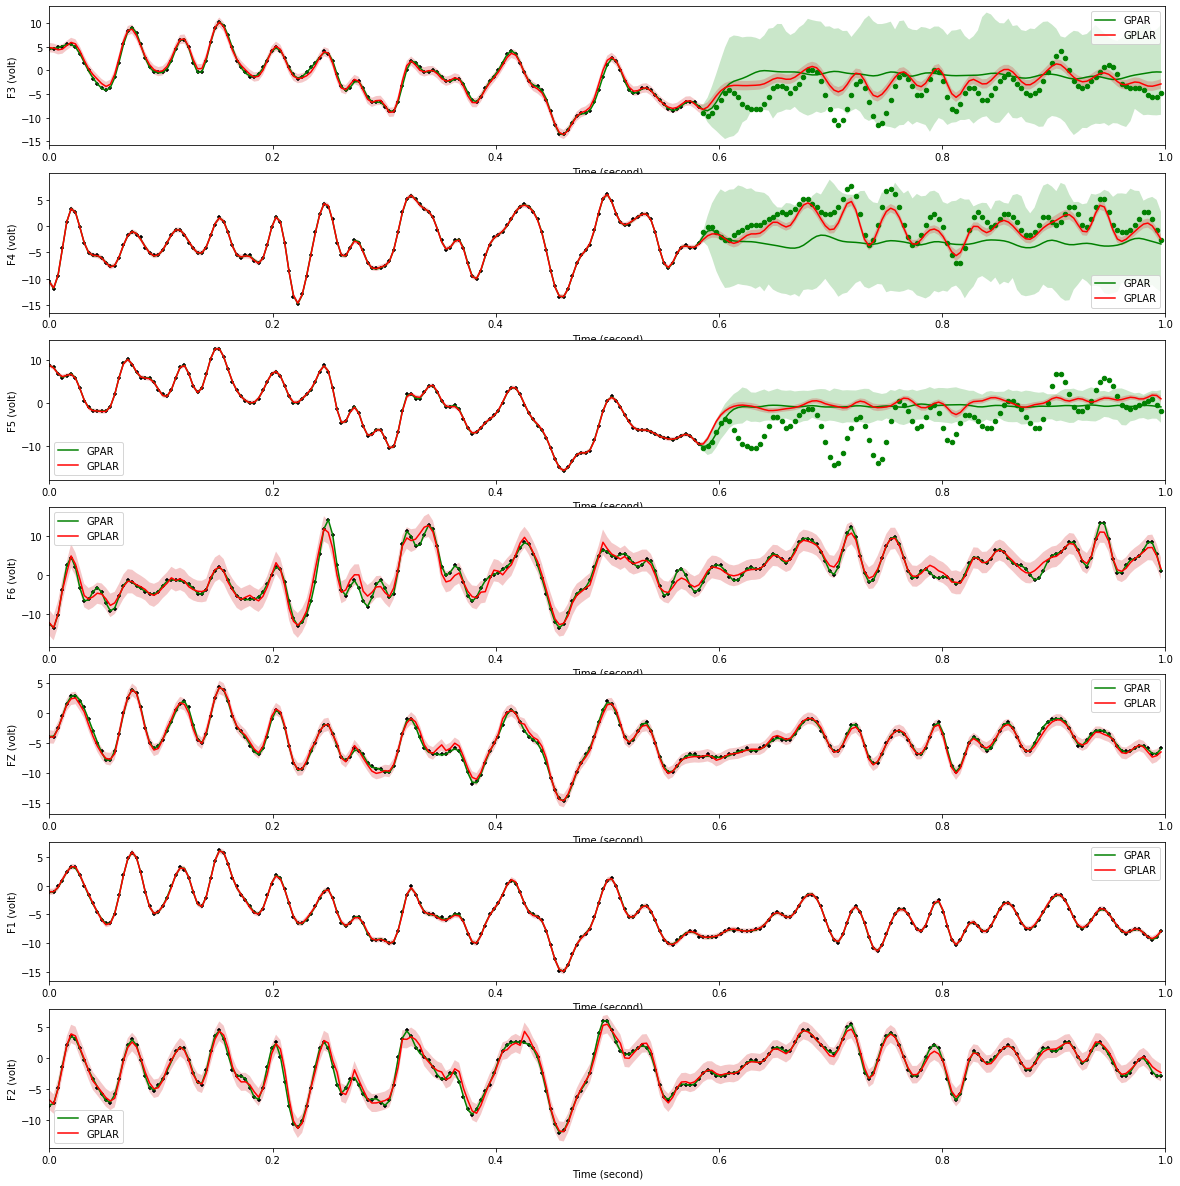

In [28]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_2.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

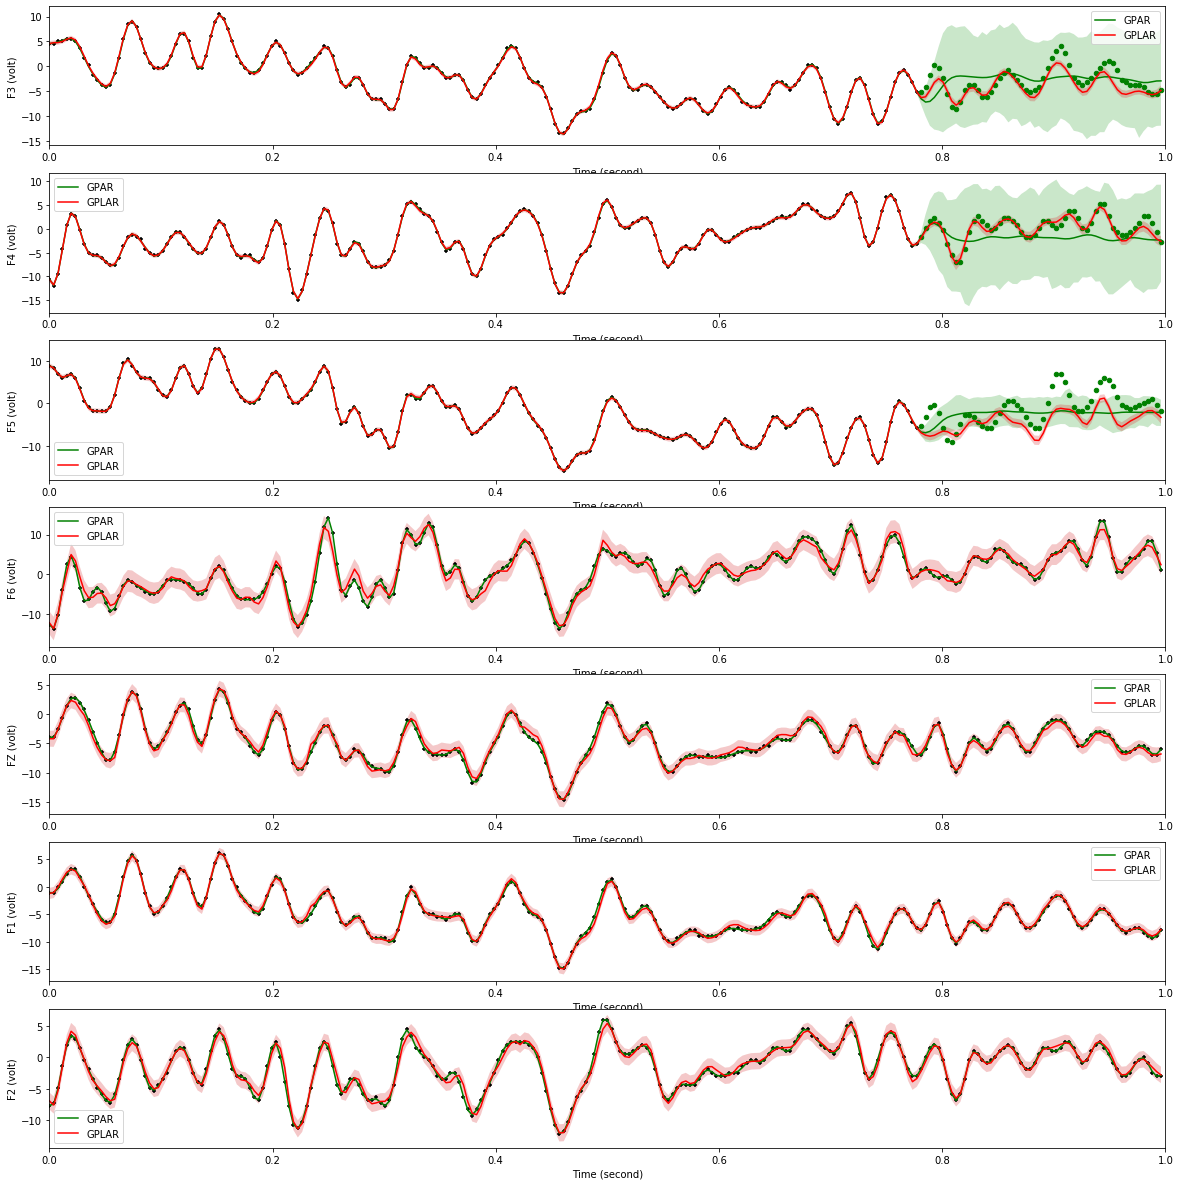

In [41]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_2.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

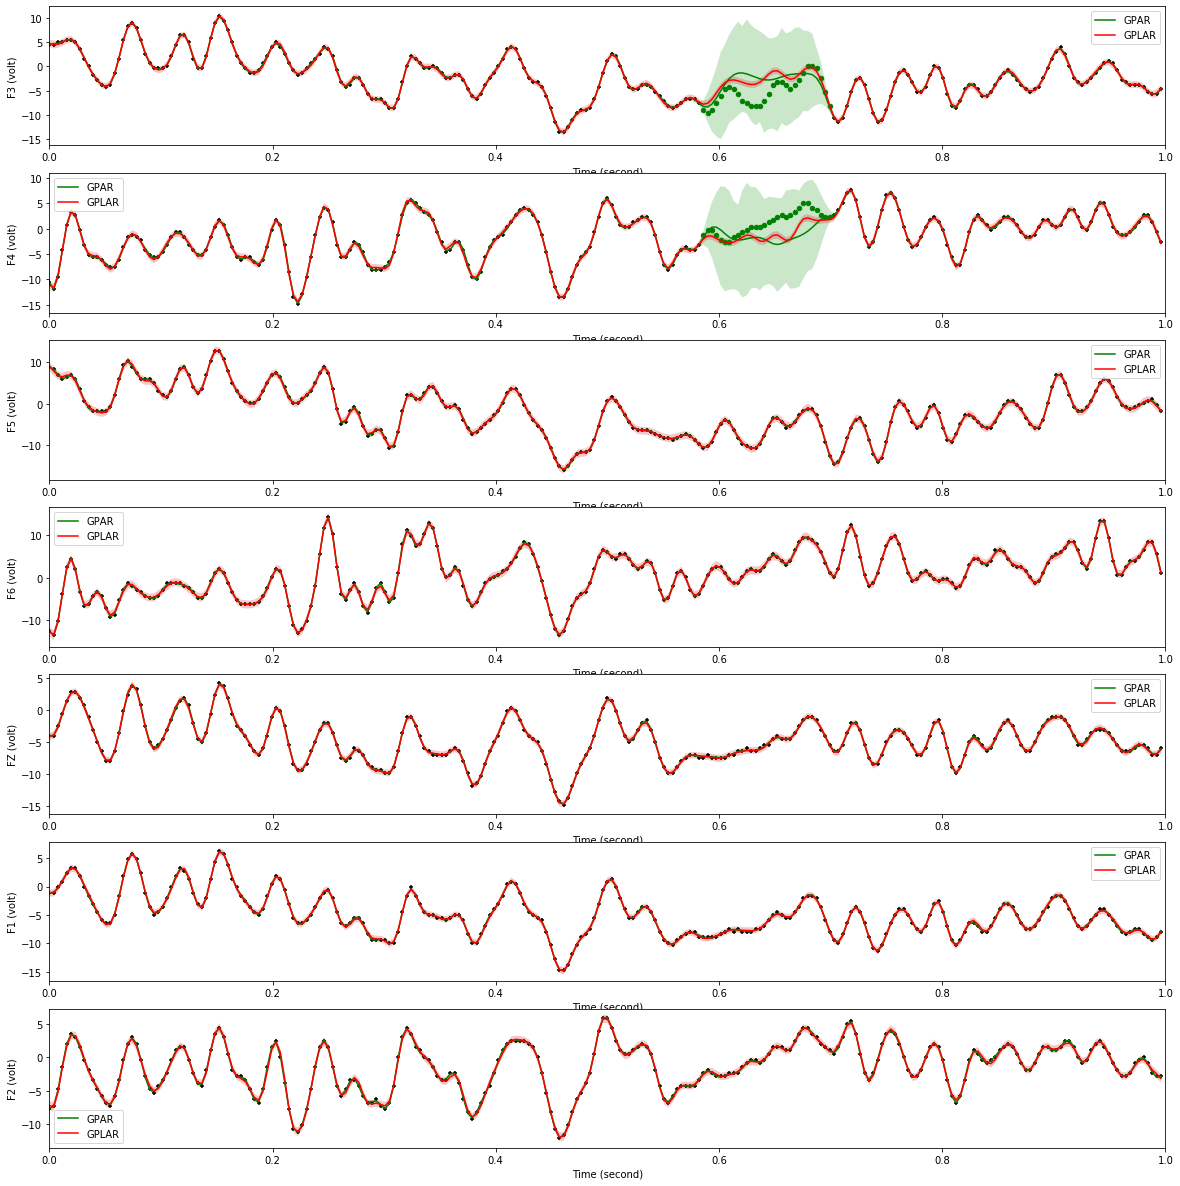

In [11]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_2.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)

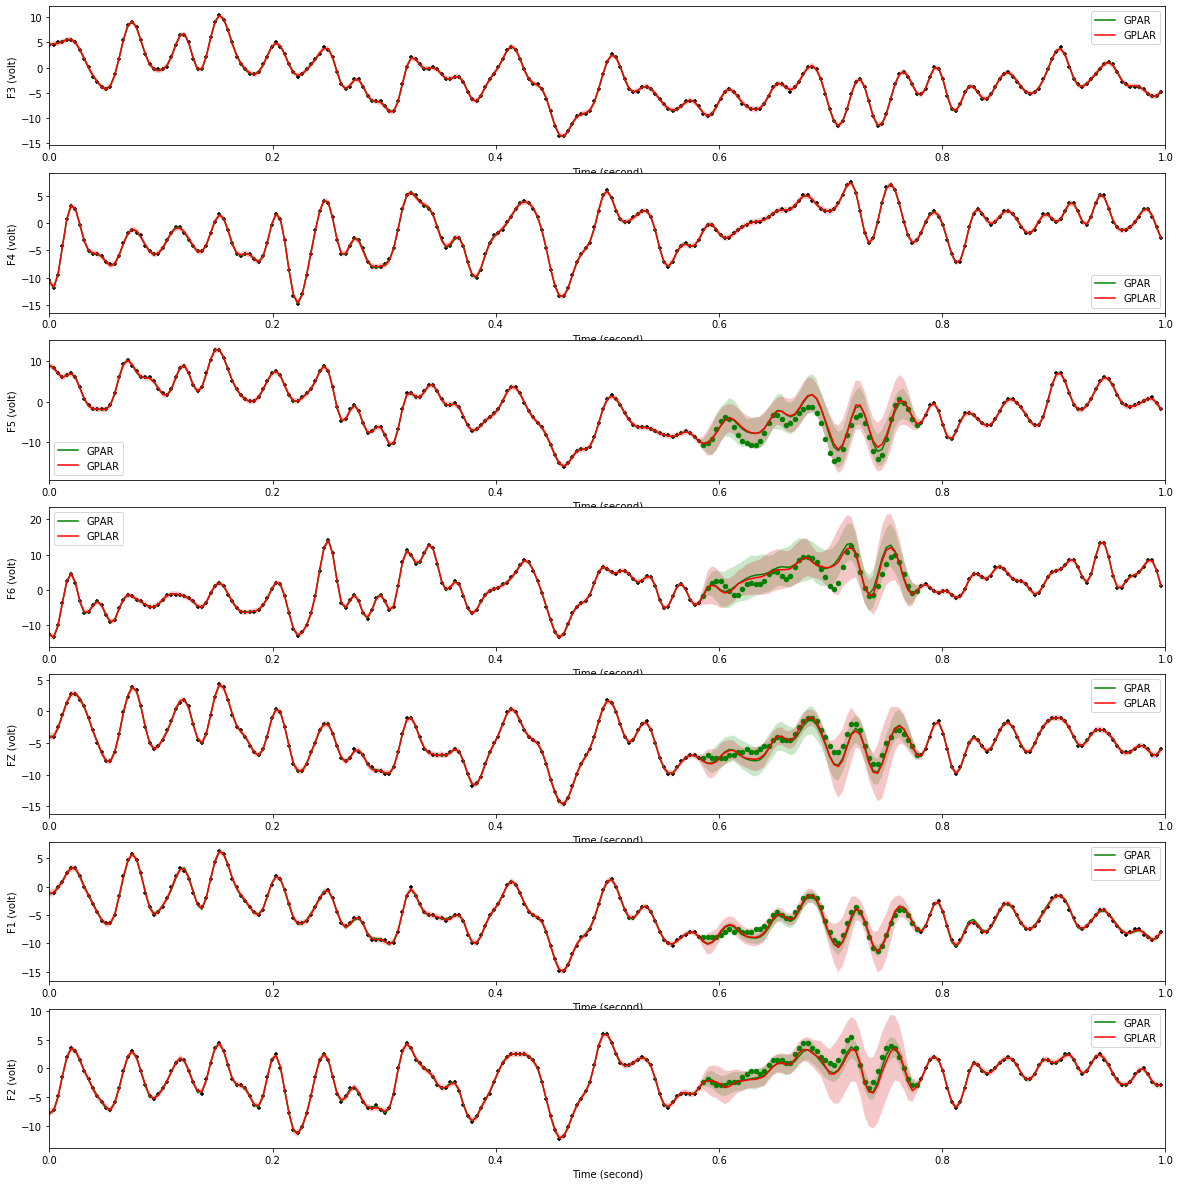

In [20]:
plt.figure(figsize=(20, 21))
x = np.array(eeg_train_2.index)
for i, name in enumerate(eeg_train_2.columns):
    p = list(eeg_train_2.columns).index(name)  # Index of output.
    plt.subplot(7, 1, i + 1)
    
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    
    #z = m_c_eeg_p.inducing_inputs.Z.value()
    #q_mu = m_c_eeg_p.layers[p].q_mu.value() * stds_eeg[p] + means_eeg[p]
    #q_std = np.sqrt(np.diagonal(tf.matmul(m_c_eeg_p.layers[p].q_sqrt, m_c_eeg_p.layers[p].q_sqrt, transpose_b=True)))*stds_eeg[p]
    #q = np.concatenate((z,q_mu,q_std), axis=1)
    #q = q[q[:,0].argsort(axis=0)]
    
    #plt.scatter(z, q_mu, c='blue', label='q_mu', s=15)
    #plt.fill_between(z[:,0], q_mu[:,0] - 1.96*q_std, q_mu[:,0] + 1.96*q_std, facecolor='tab:blue', alpha=.25)
    
    plt.scatter(x, y_eeg[:, p], c='black', s=15, marker='+')
    if name in eeg_test_2.columns:
        plt.scatter(eeg_test_2[name].index, eeg_test_2[name], c='green', s=20)
    plt.xlabel('Time (second)')
    plt.xlim(0, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
#plt.savefig('eeg_2.png',dpi=400)